# Classification. MNIST

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
import numpy as np
import pandas as pd

In [4]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as pl

Saving figure some_digit_plot


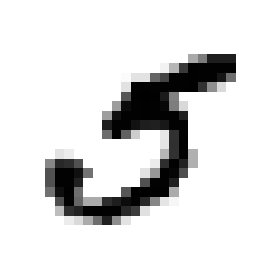

In [8]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [9]:
y[36000]


5

In [10]:
y = y.astype(np.uint8)

In [11]:
X_train, X_test, y_train, y_test =  X[:60000], X[60000:], \
                                    y[:60000], y[60000:]

In [12]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a binary classifier

In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

## Performance measures

In [16]:
from sklearn.model_selection import cross_val_score

In [17]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96225, 0.9645 , 0.94765])

In [18]:
from sklearn.base import BaseEstimator

In [19]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_5_clf = Never5Classifier()

In [21]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

## Confusion matrix

In [22]:
from sklearn.model_selection import cross_val_predict

In [23]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
confusion_matrix(y_train_5, y_train_pred)

array([[53417,  1162],
       [ 1350,  4071]], dtype=int64)

Each row in a confusion matrix represents an *actual class*, while each column represents a *predicted class*. The first row of this matrix considers non-5 images (the *negative class*): 53,417 of them were correctly classified as non-5s (they are called *true negatives*), while the remainin 1,162 were wrongly classified as 5s (*false positives*). The second row considers the images of 5s (the *positive class*): 1,350 were wrongly classified as non-5s (*false negatives*), while the remaining 4,071 wever correctly classified as 5s (*true positives*).

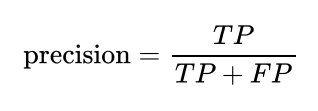

TP is the number of true positives, and FP is the number of false positives

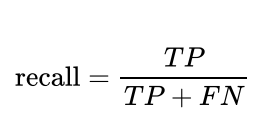

FN is, of course, the number of false negatives

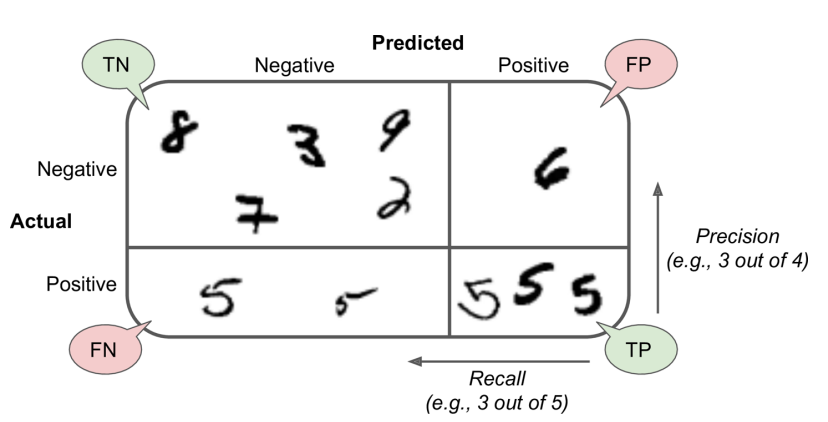

## Precision and recall

In [26]:
from sklearn.metrics import precision_score, recall_score

In [27]:
precision_score(y_train_5, y_train_pred)

0.7779476399770686

In [28]:
recall_score(y_train_5, y_train_pred)

0.7509684560044272

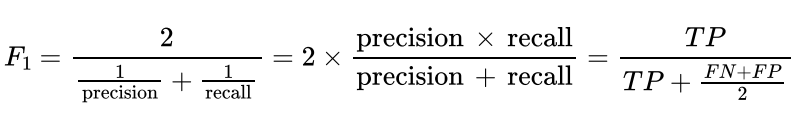

The F1 score is *harmonic mean* of precision and recall. Whereas the regualar mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

In [29]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7642200112633752

## Precision/Recall trade-off

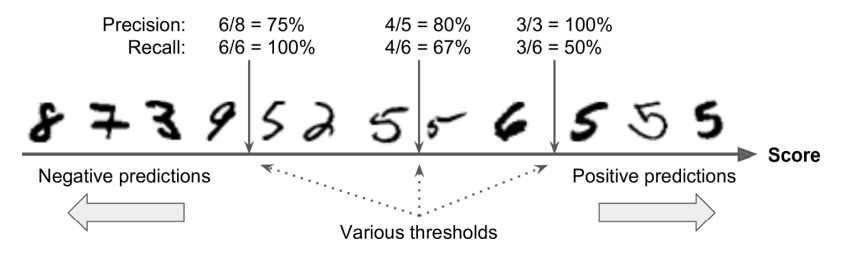

If that score is greater that a threshold, it assigns the instancce to the positive class; otherwise it assigns it to thte negative class. Suppose the *decision threshold* is positioned at the central arrow (between the two 5s): you will find 4 true positives (actual 5s) on the right of that threshold, and I false positive (actually a 6).

In [30]:
y_scores = sgd_clf.decision_function([some_digit])

In [31]:
y_scores

array([150526.40944343])

In [32]:
threshold = 0

In [33]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [34]:
threshold = 200000

In [35]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [36]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

In [37]:
from sklearn.metrics import precision_recall_curve

In [38]:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [39]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


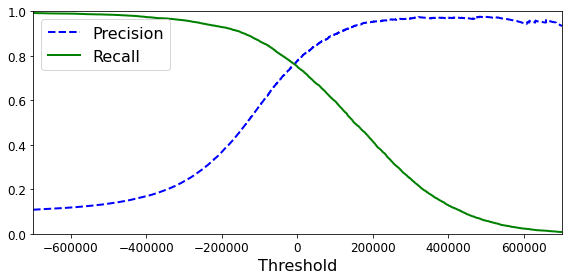

In [40]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

Another wat to select a good precision/recall trade-off is to plot precision directly against recall, as shown bellow

Saving figure precision_vs_recall_plot


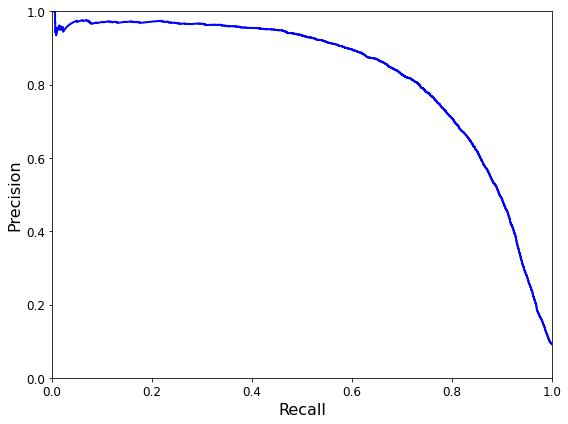

In [41]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

Suppose you decide to aim for 90% preciison. You look up the first plot and find that you need to use a threshold of about 8,000. To be more precise you can search for the lowest threshold that fives you at least 90% precision (np.argmax() will give you the first index of the maximum value, which in this case means the first *True* value):

In [42]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [43]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [44]:
precision_score(y_train_5, y_train_pred_90)

0.9001128668171557

In [45]:
recall_score(y_train_5, y_train_pred_90)

0.5884523150710201

> If someone says, "Let's reach 99% precision," you should ask, "At what recall?"

## The ROC curve

The *receiver operation characteristic* (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision.recall curve, but instead of plotting precision versus recall, the ROC curve plots the *true positive rate* (another name for recall) against the *false positive rate* (FPR).


The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 - the *true negative rate* (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called *specificity*. Hence, the ROC curve plots *sensitivity* (recall) versus I - *specificity*.

In [46]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

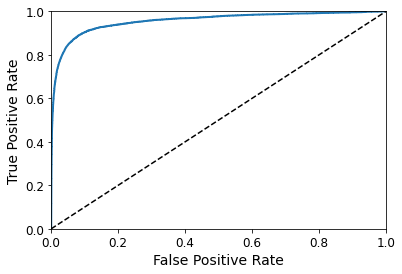

In [47]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
plot_roc_curve(fpr, tpr)
plt.show()

One way to compare classifier is to measure the *area under the curve* (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5

In [48]:
from sklearn.metrics import roc_auc_score

In [49]:
roc_auc_score(y_train_5, y_scores)

0.9562435587387078

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, 
                                   cv=3, method="predict_proba")

In [52]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, 
                                                     y_scores_forest)


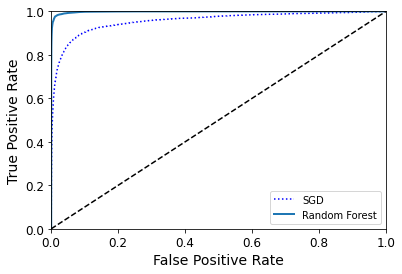

In [53]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [54]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983730844244434

## Multiclass classifier

One-versus-all - OvA or one-versus-the-rest

One-versus-one - Ovo

Scikit-learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm

In [55]:
from sklearn.svm import SVC

In [56]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [57]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

In [58]:
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [59]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-152619.46799791, -441052.22074349, -249930.3138537 ,
        -237258.35168498, -447251.81933158,  120565.05820991,
        -834139.15404835, -188142.48490477, -555223.79499145,
        -536978.92518594]])

In [60]:
np.argmax(some_digit_scores)

5

In [61]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [63]:
sgd_clf.classes_[5]

5

If you want to force Scikit-leran to use one-versus-one or one-versus-the-rest, you can use the *OneVsOneClassifier*. For example, this code creates a multiclass classifier using the OvR strategy, based on an SVC.

In [64]:
from sklearn.multiclass import OneVsRestClassifier

In [66]:
ovr_clf = OneVsRestClassifier(SVC())

In [67]:
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [68]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [69]:
len(ovr_clf.estimators_)

10